In [73]:
import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cleandata
%matplotlib inline

# Golf Game Improvement Model


### Personal Data

Each record in my data set represents a round of golf that I played and includes details about that round such as the score and stats (e.g. number of putts, number of fairways). I cleaned the data below...

In [85]:
# Import Round Data
personal_scores = cleandata.load_personal_data()
personal_scores.head()

,Date,Course,Course Rating,Par,Score,Putts,Fairways,Greens,Holes Played,Relative Score,Relative Score w/ Rating
0,2019-07-20,Wilshire Country Club,71.8,71,98,34.0,5.0,4.0,18,9,26.2
2,2019-07-27,Wilshire Country Club,71.8,71,98,33.0,10.0,3.0,18,20,26.2
3,2019-06-16,Sandpiper,75.1,72,86,32.0,5.0,4.0,18,15,10.9
4,2019-08-17,Wilshire Country Club,71.8,71,91,29.0,5.0,0.0,18,18,19.2
5,2019-08-24,Wilshire Country Club,71.8,71,83,28.0,5.0,4.0,18,12,11.2


**Scores Plotted Over Time**

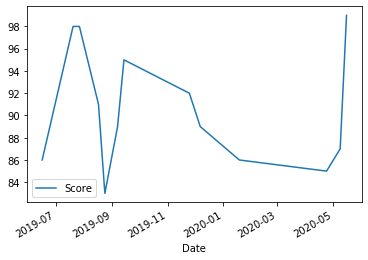

In [81]:
personal_scores.plot(x="Date", y="Score")

**Distribution of Scores**

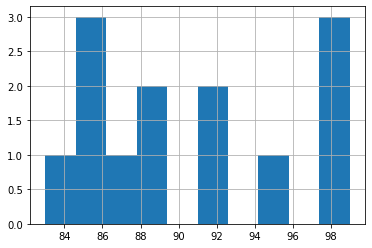

In [31]:
# Distribution of scores
personal_scores['Score'].hist()

**Average Stats Given Score Ranges**

In [32]:
def find_stats(input_score):
    df = personal_scores[(personal_scores["Score"] > input_score) & (personal_scores["Score"] < input_score + 10) & (personal_scores["Holes Played"] == 18)]
    df = pd.DataFrame(df[['Putts','Fairways','Greens']].mean())
    df.columns = [str(input_score) + 's']
    return df

shoot_80s = find_stats(input_score = 80)
shoot_90s = find_stats(input_score = 90)
shoot_80s.merge(shoot_90s, left_index=True, right_index = True)

,80s,90s
Putts,30.571429,34.000000
Fairways,5.857143,5.833333
Greens,4.000000,3.166667


**Correlation Matrix of Scores and Stats**

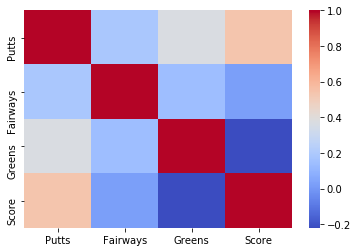

In [33]:
correlations = personal_scores[["Putts", "Fairways", "Greens", "Score"]].corr()
sns.heatmap(correlations, cmap='coolwarm')

**Scatterplot: The Relationship Between Stats and Score**

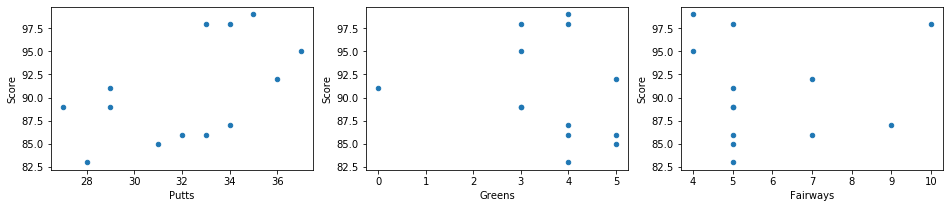

In [53]:
fig, axs = plt.subplots(1, 3, sharey=False)
personal_scores.plot(kind="scatter", x="Putts", y="Score", ax=axs[0], figsize=(16, 3))
personal_scores.plot(kind="scatter", x="Greens", y="Score", ax=axs[1], figsize=(16, 3))
personal_scores.plot(kind="scatter", x="Fairways", y="Score", ax=axs[2], figsize=(16, 3))

### PGA Tour Data

Using a publically available dataset with the stats and average scores for professional golfers could be a way of expanding my dataset. Each record in this PGA Tour dataset represents a player and a summary of statistics for all the rounds they played between 2010 and 2018.

In [78]:
# Import PGA Tour Data
pro_scores = cleandata.load_pro_data()
pro_scores.head()

,Greens,Putts,Score,Fairways,Holes Played
0,13.2318,29.93,69.617,10.5266,18
1,12.2796,29.31,70.758,10.3012,18
2,12.3606,29.12,70.432,10.1136,18
3,12.3840,29.17,70.015,10.0716,18
4,12.0816,29.11,71.038,10.0016,18


**Distribution of Scores**

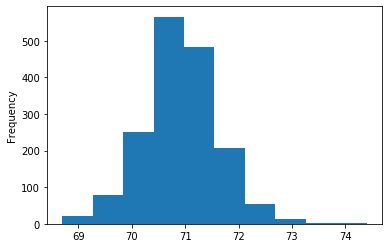

In [79]:
pro_scores['Score'].plot(kind='hist')

**Average Stats Given Scores**

In [56]:
def find_avg_stats(score):
    stats = pro_scores[(pro_scores['Score'] >= score) & (pro_scores['Score'] < (score+1))].mean()
    return stats.rename(score)

attributes = pd.DataFrame()
for i in range(69,75):
    stats = find_avg_stats(i)
    attributes = attributes.append(stats)
    
attributes

,Fairways,Greens,Holes Played,Putts,Score
69,8.668312,12.181105,18.0,28.902197,69.676947
70,8.689830,11.945433,18.0,29.111790,70.601705
71,8.527404,11.660652,18.0,29.246195,71.385104
72,8.320646,11.344292,18.0,29.486923,72.297560
73,8.132400,10.861457,18.0,29.327143,73.219714
74,6.187300,9.720000,18.0,28.905000,74.331000


### Adding Pro Scores to My Scores

By adding in average stats for professional golfers, I can create a more robust model that works for my scores as well as the low scores that professionals shoot, and hopefully the scores in between too.

In [57]:
new = pd.DataFrame()
for i in range(70,75):
    test = pro_scores[(pro_scores['Score'] >= i) & (pro_scores['Score'] < (i+1))].sample(n=2, random_state=24)
    new = new.append(test, ignore_index = True)
personal_scores_added_pros = pd.concat([personal_scores,new])

**Scatterplot: The Relationship Between Stats and Score**

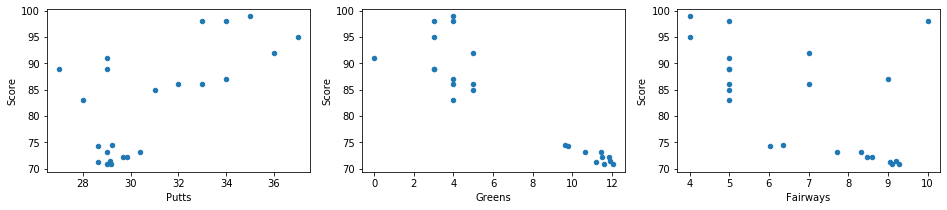

In [58]:
fig, axs = plt.subplots(1, 3, sharey=False)
personal_scores_added_pros.plot(kind="scatter", x="Putts", y="Score", ax=axs[0], figsize=(16, 3))
personal_scores_added_pros.plot(kind="scatter", x="Greens", y="Score", ax=axs[1], figsize=(16, 3))
personal_scores_added_pros.plot(kind="scatter", x="Fairways", y="Score", ax=axs[2], figsize=(16, 3))

### Applying a Linear Model

Understand the linear relationship between putts, greens, and fairways, with a target variable of score.

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
def fit_and_score_linear_model(df,target,model='linear'):
    
    features = ['Putts','Fairways','Greens']
    X = df[features]
    y = df[target]
    
    lr = LinearRegression()
    lr.fit(X,y)
    y_pred = lr.predict(X)
    r2 = lr.score(X,y)
    coefficients = lr.coef_
    intercept = lr.intercept_
    frame = pd.DataFrame({'Original': y,'Predicted': y_pred})
    model = lr
    
    print('coeffs:'+str(coefficients))
    print('intercept:'+str(intercept))
    print('r2:'+str(r2))
    
    return {'model':model, 'vals': frame,'score': r2, 'coeffs': coefficients}

In [61]:
test1 = fit_and_score_linear_model(personal_scores,'Score','linear')

coeffs:[ 1.25041109 -0.11996913 -1.98723359]
intercept:58.29583056169011
r2:0.5005286435494004


In [62]:
test2 = fit_and_score_linear_model(personal_scores_added_pros,'Score','linear')

coeffs:[ 1.23777615 -0.06265284 -1.91760438]
intercept:58.10202779759851
r2:0.9205079679115369


In [63]:
test3 = fit_and_score_linear_model(personal_scores,'Relative Score w/ Rating','linear')

coeffs:[ 1.35318548 -0.18625921 -2.00997446]
intercept:-15.885156320676867
r2:0.5091411045028722


In [64]:
IDEAL_MODEL = test2['model']
with open('exports/Score.pkl', 'wb') as picklefile:
    pickle.dump(IDEAL_MODEL, picklefile)

The best performing model uses the data that has pro scores included. The coefficients from the linear model can be used to create an equation that predicts the score based on the number of putts, fairways, and greens. The number of greens hit has the biggest impact on overall score.

$$y = 1.2p - .06f - 1.9g + 58$$

### Applying a Random Forest Regressor

Generate a random forest of decision trees to understand the relationship between putts, greens, and fairways, with a target variable of score.

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

In [83]:
features = ['Putts','Fairways','Greens']
target = 'Relative Score w/ Rating'
X = personal_scores[features]
y = personal_scores[target]

rf = RandomForestRegressor()
lr = LinearRegression()
kf = KFold(n_splits = 5)

scores = cross_val_score(rf,X,y,scoring='neg_mean_squared_error',cv=kf)
print('mse: ' + str(np.mean(-scores)))
scores = cross_val_score(rf,X,y,scoring='r2',cv=kf)
print('r2: ' + str(np.mean(scores)))

mse: 24.720958266666663
r2: 0.26886317474056626


### Output and Optimization

There are a few ways to use the model in order to generate a prediction. You can use the linear equation to solve for the target score given a specific stats. Or you can provide a range for each stat and use an optimization algorithm to predict the lowest score possible.


**Predict Target Score Based On Stats**

In [66]:
IDEAL_MODEL.predict(pd.DataFrame({'Putts': [36.0],'Fairways': [8.0],'Greens': [5.0]}))[0]

92.57272466952428

**Predict Target Score Based On Range of Stats**

In [67]:
from scipy.optimize import linprog

c = IDEAL_MODEL.coef_
putts_bounds = (30,32)
fairways_bounds = (5,7)
greens_bounds = (6,9)
result = linprog(c,  bounds=[putts_bounds, fairways_bounds, greens_bounds])
output = result.fun + IDEAL_MODEL.intercept_
output

77.53830308169393

**Predict Stats Based On Target Score**

In [68]:
features = ['Putts','Fairways','Greens']
X = personal_scores_added_pros['Score'].values.reshape(-1, 1)
models = {}
for feature in features:
    y = personal_scores_added_pros[feature]
    lr = LinearRegression()
    lr.fit(X,y)
    y_pred = lr.predict(np.array([72]).reshape(-1, 1))
    r2 = lr.score(X,y)
    models[feature] = lr
    
    with open('exports/'+feature+'.pkl', 'wb') as picklefile:
        pickle.dump(IDEAL_MODEL, picklefile)
    

def get_target_stats(target_score):
    target_stats = []
    for feature in features:
        target_stat = models[feature].predict(np.array([target_score]).reshape(-1, 1))
        target_stats.append(target_stat[0])
    
    return target_stats

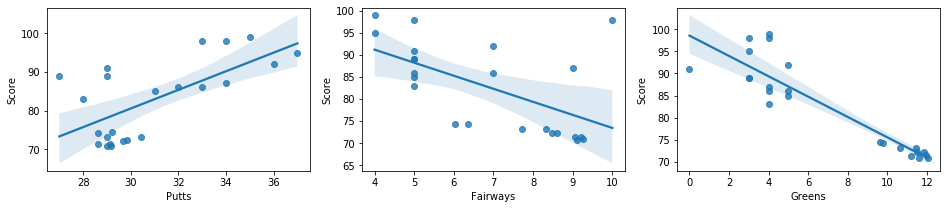

In [69]:
fig, axs = plt.subplots(1, 3, sharey=False,figsize=(16, 3))
sns.regplot(x=personal_scores_added_pros.Putts, y=personal_scores_added_pros.Score, ax=axs[0])
sns.regplot(x=personal_scores_added_pros.Fairways, y=personal_scores_added_pros.Score, ax=axs[1])
sns.regplot(x=personal_scores_added_pros.Greens, y=personal_scores_added_pros.Score, ax=axs[2])

In [70]:
get_target_stats(75)

[29.50407144986724, 7.744136175930084, 9.660391288803709]